# Loading

In [18]:
import tobii_research as tr
from utils import *

def get_tracker():
  all_eyetrackers = tr.find_all_eyetrackers()

  for tracker in all_eyetrackers:
    print("Model: " + tracker.model)
    print("Serial number: " + tracker.serial_number) 
    print(f"Can stream eye images: {tr.CAPABILITY_HAS_EYE_IMAGES in tracker.device_capabilities}")
    print(f"Can stream gaze data: {tr.CAPABILITY_HAS_GAZE_DATA in tracker.device_capabilities}")
    return tracker

tracker = get_tracker()

Model: Tobii Pro Fusion
Serial number: TPFC6-010203104285
Can stream eye images: True
Can stream gaze data: True


In [27]:
import time

for i in range (1000):
    start = time.time()
    gaze_data(tracker, 0.0)
    end = time.time()

In [2]:
def build_dataset(tracker, label, add_on = False, df_orig = pd.DataFrame(), 
                  time_step_sec = 0.01, tot_time_min = 0.1):
    
    global global_gaze_data
    
    intervals = math.ceil((tot_time_min * 60) / time_step_sec)
    dict_list = []
    
    for _ in range(intervals):
        data = gaze_data(tracker, time_step_sec)
        print(data)
        dict_list.append(data)
        
    tot_dict = combine_dicts_with_labels(dict_list)
    df = pd.DataFrame(tot_dict).T
    df['type'] = label
    
    index = range(intervals)
    df.index = index
        
    if add_on:
        df_new = pd.concat([df_orig, df])
        df_new = df_new.reset_index(drop=True)
        return df_new
    
    else:
        return df, dict_list

In [3]:
dict[0]

dict[0]

In [9]:
tracker

In [5]:
gaze_data(tracker)

{'device_time_stamp': 1166756881,
 'system_time_stamp': 12121798586,
 'left_gaze_point_on_display_area': (0.23103772103786469, 0.48897507786750793),
 'left_gaze_point_in_user_coordinate_system': (-50.74472427368164,
  64.74356079101562,
  12.922948837280273),
 'left_gaze_point_validity': 1,
 'left_pupil_diameter': 5.5030670166015625,
 'left_pupil_validity': 1,
 'left_gaze_origin_in_user_coordinate_system': (-53.65989303588867,
  -35.46145248413086,
  603.879150390625),
 'left_gaze_origin_in_trackbox_coordinate_system': (0.6209567189216614,
  0.5803156495094299,
  0.3557988703250885),
 'left_gaze_origin_validity': 1,
 'right_gaze_point_on_display_area': (0.32799309492111206,
  0.40930771827697754),
 'right_gaze_point_in_user_coordinate_system': (-32.452293395996094,
  73.57124328613281,
  16.135927200317383),
 'right_gaze_point_validity': 1,
 'right_pupil_diameter': 5.6516571044921875,
 'right_pupil_validity': 1,
 'right_gaze_origin_in_user_coordinate_system': (7.4803361892700195,
  -38

In [8]:
data, dict_list = build_dataset(tracker, 'cat', time_step_sec=0.01, tot_time_min=0.15)
data.head()

EyeTrackerInvalidOperationError: "The operation is invalid in this context. 'invalid_operation'"

In [34]:
data.to_csv("lam_looking_for_bounds.csv")

# Visualizations

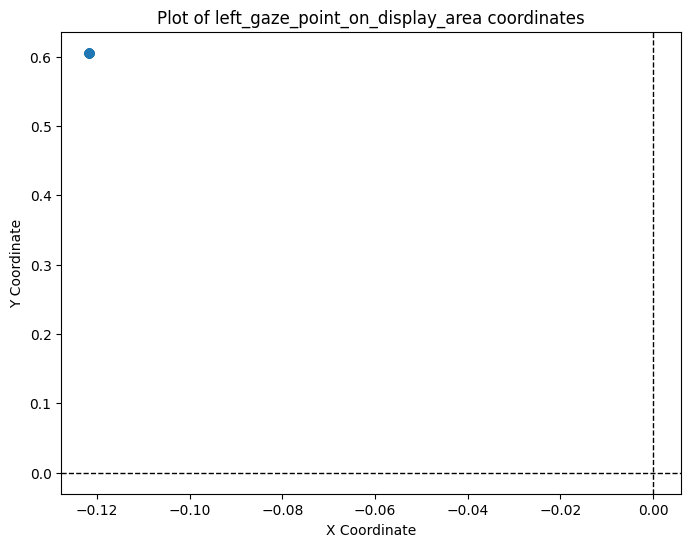

In [19]:
from matplotlib import pyplot as plt

# plot coordinates (you can use this for testing or for funsies)
# takes in a dataframe (call build_dataset first)
#          and a column_name (string)

def translate2ScreenX(xcoord):
    return 2*xcoord - 1

def translate2ScreenY(ycoord):
    return -2*ycoord + 1

def plot_coordinates(dataframe, column_name):
    # extract x and y coordinates from the specified column
    x_values = [point[0] for point in dataframe[column_name]]
    y_values = [point[1] for point in dataframe[column_name]]
    x_values = list(map(translate2ScreenX, x_values))
    y_values = list(map(translate2ScreenY, y_values))

    
    # plot the coordinates
    plt.figure(figsize=(8, 6))
    plt.scatter(x_values, y_values, marker='o', label=column_name)
    plt.title(f'Plot of {column_name} coordinates')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.axvline(0, color='black', linestyle='--', linewidth=1)
    
    # plt.ylim(-1, 1)
    # plt.xlim(-1, 1)
    plt.show()
    
plot_coordinates(data, 'left_gaze_point_on_display_area')


In [22]:
import numpy as np

x_values = [translate2ScreenX(point[0]) for point in data['left_gaze_point_on_display_area']] 
y_values = [translate2ScreenY(point[1]) for point in data['left_gaze_point_on_display_area']] 

print(min(x_values))
print(max(x_values))

print('\n')
print(min(y_values))
print(max(y_values))

-0.12164908647537231
-0.12164908647537231


0.60564786195755
0.60564786195755


# Make eye detection functions

In [16]:
# example
# function should accept a dictionary of gaze data (look at what the gaze_data function returns)
# when we call build_dataset, we also make a call to gaze_data, so we'll be able to 
# modify build_dataset to check for movement detection at every timestep.

# things to consider:
# this sample code only takes in one row/timestep
# if we want to use acceleration or speed of eye movements,
# we need to look at multiple rows at a time



def detect_movement_example(data_dict):
    # data_dict should only have 1 row
    assert(len(data_dict) == 1)  # remove this in practice, just keeping it here for initial testing
    
    # add checks for validity
            
    # get eye coordinates
    left_x, left_y = data.left_gaze_point_on_display_area[0]
    right_x, right_y = data.right_gaze_point_on_display_area[0]
    
    # do some kind of detection
    direction = round(math.atan(left_y/left_x), 1)
    magnitude = round(math.sqrt(left_x**2 + left_y**2), 1)
    return direction, magnitude
    
# test your function
data2 = pd.DataFrame(data.iloc[0]).transpose()  # call build_dataset and get a row
detect_movement_example(data2)                  # call detect_movement


(1.0, 0.7)

In [18]:
def detect_movement_example_with_scaling(data_dict):
    # data_dict should only have 1 row
    assert len(data_dict) == 1 
    
    left_x, left_y = data_dict['left_gaze_point_on_display_area'][0]
    right_x, right_y = data_dict['right_gaze_point_on_display_area'][0]
    
    if left_x == 0:
        direction_left = math.pi / 2 if left_y > 0 else -math.pi / 2
    else:
        direction_left = math.atan(left_y / left_x)
    
    scaled_direction_left = direction_left / (math.pi / 2)
    magnitude_left = math.sqrt(left_x**2 + left_y**2)
    
    scaled_magnitude_left = magnitude_left / math.sqrt(2)
    
    return scaled_direction_left, scaled_magnitude_left

data2 = pd.DataFrame(data.iloc[0]).transpose()  # call build_dataset and get a row
detect_movement_example_with_scaling(data2)     # call detect_movement

(0.6300972005027725, 0.5076647282166126)

In [ ]:
# functions
# left
# right
# up 
# down
# eye roll

In [1]:
# try incorporating your function into a modified build_dataset, 
# so you can test your movement detection function while recording data

# make modifications here:

import pandas as pd
def modified_build_dataset(tracker, label, add_on = False, df_orig = pd.DataFrame(), 
                  time_step_sec = 0.5, tot_time_min = 0.1):
    
    global global_gaze_data
    
    intervals = math.ceil((tot_time_min * 60) / time_step_sec)
    dict_list = []
    
    for _ in range(intervals):
        data = gaze_data(tracker, time_step_sec)
        dict_list.append(data)
    
    tot_dict = combine_dicts_with_labels(dict_list)
    df = pd.DataFrame(tot_dict).T
    df['type'] = label
        
    if add_on:
        df_new = pd.concat([df_orig, df])
        df_new = df_new.reset_index(drop=True)
        return df_new
    
    else:
        return df, dict_list

NameError: name 'pd' is not defined

In [1]:
from utils import build_dataset_from_csv
build_dataset_from_csv("lam_looking_left.csv", "test00")

/Users/annmarievo/Library/Mobile Documents/com~apple~CloudDocs/Documents/UW/Synaptech/Opticars/opticars/utils.py:140: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'None' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df['left_pupil_diameter'].fillna("None", inplace=True)
/Users/annmarievo/Library/Mobile Documents/com~apple~CloudDocs/Documents/UW/Synaptech/Opticars/opticars/utils.py:141: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'None' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df['right_pupil_diameter'].fillna("None", inplace=True)


,Unnamed: 0,device_time_stamp,system_time_stamp,left_gaze_point_on_display_area,left_gaze_point_in_user_coordinate_system,left_gaze_point_validity,left_pupil_diameter,left_pupil_validity,left_gaze_origin_in_user_coordinate_system,left_gaze_origin_in_trackbox_coordinate_system,left_gaze_origin_validity,right_gaze_point_on_display_area,right_gaze_point_in_user_coordinate_system,right_gaze_point_validity,right_pupil_diameter,right_pupil_validity,right_gaze_origin_in_user_coordinate_system,right_gaze_origin_in_trackbox_coordinate_system,right_gaze_origin_validity,type
0,timestep_1,1251393795,586300009912,"(0.7770590782165527, 0.5302660465240479)","(52.2723388671875, 60.16826248168945, 11.25765...",1,3.968063,1,"(-32.60731887817383, -14.830509185791016, 664....","(0.5661173462867737, 0.5332939624786377, 0.483...",1,"(0.742099404335022, 0.5308240056037903)","(45.676536560058594, 60.10643005371094, 11.235...",1,4.016312,1,"(27.087200164794922, -17.86370849609375, 667.4...","(0.44556093215942383, 0.5389994382858276, 0.48...",1,test00
1,timestep_2,1251893811,586300509806,"(-0.025754651054739952, 0.22233116626739502)","(-99.19337463378906, 94.28945922851562, 23.676...",1,4.140854,1,"(-34.54977798461914, -15.024839401245117, 667....","(0.5697054266929626, 0.5336617827415466, 0.490...",1,"(-0.012542182579636574, 0.2494274377822876)","(-96.7005844116211, 91.28702545166016, 22.5839...",1,4.192245,1,"(25.172290802001953, -18.071969985961914, 669....","(0.44961994886398315, 0.5393798351287842, 0.49...",1,test00
2,timestep_3,1252410503,586301026536,"(0.3505152463912964, 0.3328867554664612)","(-28.20307159423828, 82.0391616821289, 19.2180...",1,4.177078,1,"(-34.94734573364258, -14.583173751831055, 667....","(0.570563793182373, 0.532778799533844, 0.48931...",1,"(0.3532131016254425, 0.31423211097717285)","(-27.69407081604004, 84.10623168945312, 19.970...",1,4.241455,1,"(24.73162269592285, -17.50441551208496, 669.55...","(0.45048874616622925, 0.5382461547851562, 0.49...",1,test00
3,timestep_4,1252410503,586301026536,"(0.3505152463912964, 0.3328867554664612)","(-28.20307159423828, 82.0391616821289, 19.2180...",1,4.177078,1,"(-34.94734573364258, -14.583173751831055, 667....","(0.570563793182373, 0.532778799533844, 0.48931...",1,"(0.3532131016254425, 0.31423211097717285)","(-27.69407081604004, 84.10623168945312, 19.970...",1,4.241455,1,"(24.73162269592285, -17.50441551208496, 669.55...","(0.45048874616622925, 0.5382461547851562, 0.49...",1,test00
4,timestep_5,1253443880,586302059918,"(-0.8714488744735718, -0.08900610357522964)","(-258.749267578125, 128.78765869140625, 36.233...",1,4.119034,1,"(-40.36039352416992, -15.948020935058594, 674....","(0.5806002616882324, 0.5354464650154114, 0.506...",1,"(-0.7561564445495605, -0.10524147748947144)","(-236.99722290039062, 130.58663940429688, 36.8...",1,4.459412,1,"(19.314624786376953, -18.224193572998047, 675....","(0.46167701482772827, 0.5395944118499756, 0.50...",1,test00
5,timestep_6,1253943906,586302559901,None,None,0,None,0,None,None,0,"(-1.0184719562530518, -0.09503379464149475)","(-286.4878845214844, 129.45558166503906, 36.47...",1,4.430206,1,"(19.85418701171875, -19.83327865600586, 676.73...","(0.4606475532054901, 0.5427696108818054, 0.508...",1,test00
6,timestep_7,1254460594,586303076557,"(-1.1236741542816162, 0.015319067984819412)","(-306.3362121582031, 117.2277603149414, 32.025...",1,4.137039,1,"(-37.828941345214844, -17.429882049560547, 676...","(0.5753879547119141, 0.5383567810058594, 0.509...",1,"(-1.0297735929489136, -0.10676711797714233)","(-288.6201477050781, 130.7556915283203, 36.949...",1,4.587433,1,"(22.151803970336914, -20.59770393371582, 687.3...","(0.45665213465690613, 0.5439755320549011, 0.53...",1,test00
7,timestep_8,1254460594,586303076557,"(-1.1236741542816162, 0.015319067984819412)","(-306.3362121582031, 117.2277603149414, 32.025...",1,4.137039,1,"(-37.828941345214844, -17.429882049560547, 676...","(0.5753879547119141, 0.5383567810058594, 0.509...",1,"(-1.0297735929489136, -0.10676